Here I train a model on synthetic data without noise generated with an assumption that there is no cavity linewidth effect on the microwave transitions. I will try a fully-connected neural network (FCNN) and a convolutional neural network (CNN).

Import libraries

In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import pandas as pd

Load datasets. X is the DR signal vs microwave frequency. Y corresponds to the parallel and normal components of the DC field. Y-data is already normalized. I don't inc

In [6]:
X_train = np.load("..\Data\X_train1.npy")
Y_train = np.load('..\Data\Y_train1.npy')

X_test = np.load('..\Data\X_val1.npy')
Y_test = np.load('..\Data\Y_val1.npy')

Normalize data, so the DR signal is between zero and one.

In [7]:
Level = np.min(X_train)
Height = np.max(X_train)-np.min(X_train)

X_train = (X_train-Level)/Height
X_test = (X_test-Level)/Height

In [8]:
X_test

array([[1.        , 0.99999845, 0.99999686, ..., 0.99999686, 0.99999845,
        1.        ],
       [0.99999994, 0.99999839, 0.99999681, ..., 0.99999681, 0.99999839,
        0.99999994],
       [0.99999978, 0.99999822, 0.99999663, ..., 0.99999663, 0.99999822,
        0.99999978],
       ...,
       [0.99946675, 0.99943539, 0.99940158, ..., 0.99940158, 0.99943539,
        0.99946675],
       [0.99979513, 0.99978365, 0.99977142, ..., 0.99977142, 0.99978365,
        0.99979513],
       [0.99948509, 0.99945484, 0.99942223, ..., 0.99942223, 0.99945484,
        0.99948509]])

Plot normalized data

Text(0, 0.5, 'DR signal')

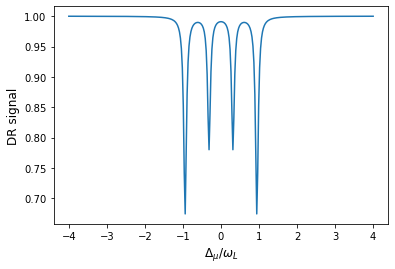

In [14]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-4,4,320), X_train[50])
ax.set_xlabel(r'$\Delta_{\mu}/\omega_{L}$', fontsize=12)
ax.set_ylabel('DR signal', fontsize=12)

# FCNN

Create model

In [15]:
model_fc = keras.models.Sequential([
    keras.layers.Dense(320, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2)
])
model_fc.compile(loss="mae", optimizer = keras.optimizers.Adam(), metrics = 'mae')

Create callbacks

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_mae', restore_best_weights=True) #stop if val_mae is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=100) # Change learning rate is validation loss is not improving

cb_list = [early_stopping_cb, learning_rate_cb]

Train model

In [19]:
history_fc = model_fc.fit(X_train, Y_train, epochs=2000, validation_data=(X_test, Y_test), batch_size=32, callbacks=cb_list, verbose=False)

Epoch 1/2000
20/20 [==============================] - 0s 9ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0548 - val_mae: 0.0548 - lr: 0.0010
Epoch 2/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0492 - mae: 0.0492 - val_loss: 0.0608 - val_mae: 0.0608 - lr: 0.0010
Epoch 3/2000
20/20 [==============================] - 0s 6ms/step - loss: 0.0525 - mae: 0.0525 - val_loss: 0.0348 - val_mae: 0.0348 - lr: 0.0010
Epoch 4/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0589 - val_mae: 0.0589 - lr: 0.0010
Epoch 5/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0271 - val_mae: 0.0271 - lr: 0.0010
Epoch 6/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0142 - val_mae: 0.0142 - lr: 0.0010
Epoch 7/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.0405 - mae: 0.0405 - val_loss: 0.0648 - val_mae: 0.064

Plot results

7/7 [==============================] - 2s 2ms/step
max error: 0.08004853129386902
mean absolute error: 0.0020316512998457444


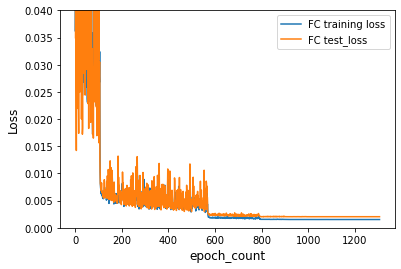

In [20]:
h_fc = history_fc.history

FC_training_data = pd.DataFrame({"FC training loss" : h_fc["loss"], "FC test_loss" :  h_fc["val_loss"]})
FC_training_data.index.name = 'FC Epoch'

fig_fc = FC_training_data.plot()
fig_fc.set_xlabel(r'epoch_count',fontsize=12)
fig_fc.set_ylabel(r'Loss',fontsize=12)
fig_fc.set_ylim(0, 0.04)

y = model_fc.predict(X_test)
print('max error:', np.max(np.abs(y-Y_test)))
print('mean absolute error:', np.mean( np.sqrt((y-Y_test)**2 )))

# CNN

Create model

In [21]:
model_cnn = keras.models.Sequential([
    keras.layers.Conv1D(kernel_size=16, activation='relu',padding='SAME',filters=32),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=8, activation='relu',padding='SAME',filters=64),
    keras.layers.Conv1D(kernel_size=8, activation='relu',padding='SAME',filters=64),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(kernel_size=4, activation='relu',padding='SAME',filters=128),
    keras.layers.Conv1D(kernel_size=4, activation='relu',padding='SAME',filters=128),
    keras.layers.Flatten(),
    # keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(2)
])

model_cnn.compile(loss="mae", optimizer = keras.optimizers.Adam(),metrics=["mae"])#loss functions are given for two output neurons

Reshape data

In [22]:
X_train_cnn = X_train[:,:,np.newaxis]
X_test_cnn = X_test[:,:,np.newaxis]

Train

In [24]:
history_cnn = model_cnn.fit(X_train_cnn, Y_train, epochs=2000, validation_data=(X_test_cnn, Y_test),batch_size=32,callbacks=cb_list, verbose=False)

Epoch 1/2000
20/20 [==============================] - 6s 21ms/step - loss: 0.3613 - mae: 0.3613 - val_loss: 0.3429 - val_mae: 0.3429 - lr: 0.0010
Epoch 2/2000
20/20 [==============================] - 0s 5ms/step - loss: 0.3308 - mae: 0.3308 - val_loss: 0.3244 - val_mae: 0.3244 - lr: 0.0010
Epoch 3/2000
20/20 [==============================] - 0s 5ms/step - loss: 0.3185 - mae: 0.3185 - val_loss: 0.3190 - val_mae: 0.3190 - lr: 0.0010
Epoch 4/2000
20/20 [==============================] - 0s 5ms/step - loss: 0.3062 - mae: 0.3062 - val_loss: 0.2650 - val_mae: 0.2650 - lr: 0.0010
Epoch 5/2000
20/20 [==============================] - 0s 5ms/step - loss: 0.2569 - mae: 0.2569 - val_loss: 0.1987 - val_mae: 0.1987 - lr: 0.0010
Epoch 6/2000
20/20 [==============================] - 0s 5ms/step - loss: 0.1638 - mae: 0.1638 - val_loss: 0.1024 - val_mae: 0.1024 - lr: 0.0010
Epoch 7/2000
20/20 [==============================] - 0s 4ms/step - loss: 0.0940 - mae: 0.0940 - val_loss: 0.1028 - val_mae: 0.10

Plot

7/7 [==============================] - 0s 9ms/step
max error: 0.023247748613357544
mean absolute error: 0.00038385678077102056


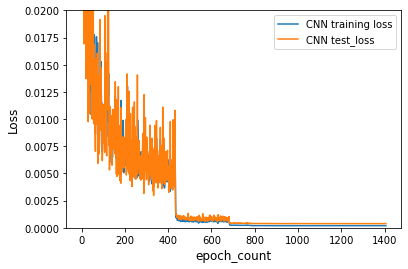

In [25]:
h_cnn = history_cnn.history

cnn_training_data = pd.DataFrame({"CNN training loss" : h_cnn["loss"], "CNN test_loss" :  h_cnn["val_loss"]})
cnn_training_data.index.name = 'CNN Epoch'

fig_cnn = cnn_training_data.plot()
fig_cnn.set_xlabel(r'epoch_count',fontsize=12)
fig_cnn.set_ylabel(r'Loss',fontsize=12)
fig_cnn.set_ylim(0, 0.02)

y = model_cnn.predict(X_test_cnn)
print('max error:', np.max(np.abs(y-Y_test)))
print('mean absolute error:', np.mean( np.sqrt((y-Y_test)**2 )))